In [ ]:
# CELL 1 — Project paths
from pathlib import Path
import os

proj_root = Path.cwd()
if proj_root.name.lower() == "notebooks":
    proj_root = proj_root.parent
    os.chdir(proj_root)

print("📂 CWD:", Path.cwd())

DATA_DIR   = proj_root / "data/image"
TAR_PATH   = DATA_DIR / "cifar-10-python.tar.gz"
CIFAR_DIR  = DATA_DIR / "cifar-10-batches-py"
OUT_IMG    = proj_root / "output" / "images"
OUT_PREP   = proj_root / "output" / "preprocess"
OUT_IMG.mkdir(parents=True, exist_ok=True)
OUT_PREP.mkdir(parents=True, exist_ok=True)

print("🗂️ DATA_DIR  :", DATA_DIR)
print("🗂️ CIFAR_DIR :", CIFAR_DIR)
print("🗂️ OUT_IMG   :", OUT_IMG)
print("🗂️ OUT_PREP  :", OUT_PREP)


📂 CWD: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing
🗂️ DATA_DIR  : d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\data
🗂️ CIFAR_DIR : d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\data\cifar-10-batches-py
🗂️ OUT_IMG   : d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\images
🗂️ OUT_PREP  : d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess


In [2]:
# CELL 2 — Extract CIFAR-10 tar.gz once
import tarfile

if not CIFAR_DIR.exists():
    assert TAR_PATH.exists(), f"Không thấy {TAR_PATH}"
    with tarfile.open(TAR_PATH, "r:gz") as tar:
        tar.extractall(DATA_DIR)
    print("✅ Extracted to:", CIFAR_DIR.resolve())
else:
    print("ℹ️ Already exists:", CIFAR_DIR.resolve())


ℹ️ Already exists: D:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\data\cifar-10-batches-py


In [3]:
# CELL 3 — Batch loader & label names
import pickle, numpy as np

def load_cifar_batch(path: Path):
    path = Path(path)
    with open(path, "rb") as f:
        d = pickle.load(f, encoding="latin1")   # keys: data, labels
    X = d["data"].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # (N,32,32,3) RGB
    y = np.array(d["labels"], dtype=np.int64)
    return X, y

meta_path = CIFAR_DIR / "batches.meta"
with open(meta_path, "rb") as f:
    meta = pickle.load(f, encoding="latin1")
LABEL_NAMES = meta["label_names"]
label2name  = {i:n for i,n in enumerate(LABEL_NAMES)}
print("🔖 Labels:", LABEL_NAMES)


🔖 Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# CELL 4 — Export PNGs into output/images/{train|test}/{class}/...
from collections import defaultdict
from PIL import Image

MODE = "sample"         # "all" hoặc "sample"
N_PER_CLASS = 100       # ảnh/lớp khi MODE="sample"

def export_split(split="train"):
    if split=="train":
        batch_files = [CIFAR_DIR / f"data_batch_{i}" for i in range(1,6)]
    elif split=="test":
        batch_files = [CIFAR_DIR / "test_batch"]
    else:
        raise ValueError("split must be 'train' or 'test'")
    per_class = defaultdict(int); total = 0
    for bf in batch_files:
        X, y = load_cifar_batch(bf)
        for i in range(len(X)):
            cls = int(y[i]); name = label2name[cls]
            if MODE=="sample" and per_class[cls] >= N_PER_CLASS: 
                continue
            cls_dir = OUT_IMG / split / name
            cls_dir.mkdir(parents=True, exist_ok=True)
            out_path = cls_dir / f"{name}_{per_class[cls]:05d}.png"
            Image.fromarray(X[i]).save(out_path)
            per_class[cls] += 1; total += 1
    return total, dict(per_class)

saved_train, stat_train = export_split("train")
saved_test,  stat_test  = export_split("test")
print(f"✅ Exported {saved_train} train, {saved_test} test → {OUT_IMG}")


✅ Exported 1000 train, 1000 test → d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\images


In [5]:
# CELL 5 — Collect image paths
import glob

IMG_DIR = OUT_IMG / "train"          # đổi sang "test" nếu muốn
paths   = glob.glob(str(IMG_DIR / "**" / "*.png"), recursive=True)
assert len(paths)>0, f"Không thấy ảnh trong {IMG_DIR}"
print("📦 Total images:", len(paths))
print("↪️  Example:", paths[0])


📦 Total images: 1000
↪️  Example: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\images\train\airplane\airplane_00000.png


In [6]:
# CELL 6 — Resize utils + metrics
from PIL import ImageOps
import math, time, pandas as pd
import matplotlib.pyplot as plt

TARGET_SIZES = [(128,128), (224,224)]
PAD_COLOR = (0,0,0)

PIL_INTERP = {
    "nearest": Image.NEAREST,
    "bilinear": Image.BILINEAR,
    "bicubic": Image.BICUBIC,
    "lanczos": Image.LANCZOS,
}

def letterbox_resize(im, size=(224,224), color=(0,0,0), resample=Image.BILINEAR):
    w,h = im.size; sw,sh = size
    scale = min(sw/w, sh/h)
    nw,nh = int(w*scale), int(h*scale)
    imr   = im.resize((nw,nh), resample)
    canvas= Image.new("RGB", size, color)
    canvas.paste(imr, ((sw-nw)//2, (sh-nh)//2))
    return canvas

def mse(a, b):
    a = np.asarray(a, np.float32); b=np.asarray(b, np.float32)
    return float(np.mean((a-b)**2))

def psnr(a, b, maxval=255.0):
    m = mse(a,b)
    return float("inf") if m==0 else 20.0*math.log10(maxval) - 10.0*math.log10(m)

def gray_entropy(img_rgb):
    g = np.asarray(ImageOps.grayscale(img_rgb), dtype=np.uint8)
    hist, _ = np.histogram(g, bins=256, range=(0,255), density=True)
    p = hist + 1e-12
    return float(-(p*np.log2(p)).sum())


In [7]:
# CELL 7 — Interpolation benchmark & quality vs bilinear
rows_bench, rows_quality = [], []
sample_save = 12

for size in TARGET_SIZES:
    out_dir = OUT_PREP / "resize" / f"{size[0]}x{size[1]}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # build bilinear reference per image for fair MSE/PSNR
    refs=[]
    for p in paths:
        im = Image.open(p).convert("RGB")
        refs.append(letterbox_resize(im, size=size, color=PAD_COLOR, resample=PIL_INTERP["bilinear"]))

    for name, interp in PIL_INTERP.items():
        t0=time.time(); ent=[]; psnrs=[]; mses=[]
        for i,p in enumerate(paths):
            im = Image.open(p).convert("RGB")
            out = letterbox_resize(im, size=size, color=PAD_COLOR, resample=interp)
            ent.append(gray_entropy(out))
            if name!="bilinear":
                psnrs.append(psnr(out, refs[i])); mses.append(mse(out, refs[i]))
            if i<sample_save:
                (out_dir/name).mkdir(parents=True, exist_ok=True)
                out.save(out_dir/name / f"{Path(p).stem}_{name}.png")
        dt = (time.time()-t0)*1000.0/len(paths)  # ms/img
        rows_bench.append({
            "size": f"{size[0]}x{size[1]}",
            "method": name,
            "time_ms_per_img": dt,
            "img_per_sec": 1000.0/dt if dt>0 else np.nan
        })
        rows_quality.append({
            "size": f"{size[0]}x{size[1]}",
            "method": name,
            "entropy_mean": np.mean(ent),
            "psnr_vs_bilinear_mean": np.mean(psnrs) if name!="bilinear" else np.nan,
            "mse_vs_bilinear_mean":  np.mean(mses)  if name!="bilinear" else np.nan,
        })

df_interp = pd.DataFrame(rows_bench).sort_values(["size","method"]).reset_index(drop=True)
df_iq     = pd.DataFrame(rows_quality).sort_values(["size","method"]).reset_index(drop=True)

df_interp.to_csv(OUT_PREP/"interp_benchmark.csv", index=False)
df_iq.to_csv(OUT_PREP/"interp_quality.csv", index=False)
print("✅ Saved:", OUT_PREP/"interp_benchmark.csv")
print("✅ Saved:", OUT_PREP/"interp_quality.csv")
display(df_interp); display(df_iq)


✅ Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\interp_benchmark.csv
✅ Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\interp_quality.csv


,size,method,time_ms_per_img,img_per_sec
0,128x128,bicubic,0.877432,1139.689008
1,128x128,bilinear,0.618222,1617.541923
2,128x128,lanczos,0.993236,1006.810481
3,128x128,nearest,0.767184,1303.467831
4,224x224,bicubic,1.861747,537.129834
5,224x224,bilinear,1.110718,900.318330
6,224x224,lanczos,2.058471,485.797533
7,224x224,nearest,1.533666,652.032393


,size,method,entropy_mean,psnr_vs_bilinear_mean,mse_vs_bilinear_mean
0,128x128,bicubic,7.131263,39.215660,8.998758
1,128x128,bilinear,7.097367,NaN,NaN
2,128x128,lanczos,7.148673,35.633025,20.768785
3,128x128,nearest,6.990580,29.194907,90.524370
4,224x224,bicubic,7.136933,39.421878,8.587792
5,224x224,bilinear,7.105043,NaN,NaN
6,224x224,lanczos,7.154471,35.733564,20.307375
7,224x224,nearest,6.990580,29.027118,94.101561


In [8]:
# CELL 8 — Normalization stats
def norm_01(a):  return a.astype(np.float32)/255.0
def norm_m11(a): return a.astype(np.float32)/127.5 - 1.0

# compute dataset mean/std on 224 bilinear
resized=[]
for p in paths:
    im = Image.open(p).convert("RGB")
    out= letterbox_resize(im, size=(224,224), color=PAD_COLOR, resample=PIL_INTERP["bilinear"])
    resized.append(np.asarray(out, np.uint8))

def zscore_stats(arrs):
    s0 = np.zeros(3); s1 = np.zeros(3); n = 0
    for x in arrs:
        xx = x.reshape(-1,3).astype(np.float64)
        s0 += xx.sum(axis=0); s1 += (xx**2).sum(axis=0); n += xx.shape[0]
    mean = s0/n; var = s1/n - mean**2; std = np.sqrt(np.maximum(var,1e-12)); 
    return mean, std

mean, std = zscore_stats(resized)

rows=[]
X01_mean = np.mean([norm_01(x).mean(axis=(0,1)) for x in resized], axis=0)
X01_std  = np.mean([norm_01(x).std(axis=(0,1))  for x in resized], axis=0)
rows.append({"variant":"[0,1]", "mean_R":X01_mean[0], "mean_G":X01_mean[1], "mean_B":X01_mean[2],
                       "std_R":X01_std[0],  "std_G":X01_std[1],  "std_B":X01_std[2]})

Xm_mean = np.mean([norm_m11(x).mean(axis=(0,1)) for x in resized], axis=0)
Xm_std  = np.mean([norm_m11(x).std(axis=(0,1))  for x in resized], axis=0)
rows.append({"variant":"[-1,1]", "mean_R":Xm_mean[0], "mean_G":Xm_mean[1], "mean_B":Xm_mean[2],
                        "std_R":Xm_std[0],  "std_G":Xm_std[1],  "std_B":Xm_std[2]})

rows.append({"variant":"Z-score(dataset)", "mean_R":mean[0], "mean_G":mean[1], "mean_B":mean[2],
                                      "std_R":std[0],  "std_G":std[1],  "std_B":std[2]})
df_norm = pd.DataFrame(rows)
df_norm.to_csv(OUT_PREP/"normalization_stats.csv", index=False)
print("✅ Saved:", OUT_PREP/"normalization_stats.csv")
display(df_norm)


✅ Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\normalization_stats.csv


,variant,mean_R,mean_G,mean_B,std_R,std_G,std_B
0,"[0,1]",0.490262,0.482265,0.444056,0.195924,0.192146,0.194367
1,"[-1,1]",-0.019489,-0.035478,-0.111899,0.391849,0.384291,0.388734
2,Z-score(dataset),125.015191,122.976610,113.232630,60.995400,60.328171,65.253604


In [9]:
# CELL 9 — Edge detectors
import cv2, time

def _to_u8(gray):
    return gray if gray.dtype==np.uint8 else np.clip(gray,0,255).astype(np.uint8)

def edges_sobel(gray_u8):
    g=_to_u8(gray_u8)
    gx=cv2.Sobel(g, cv2.CV_32F,1,0,ksize=3)
    gy=cv2.Sobel(g, cv2.CV_32F,0,1,ksize=3)
    mag=cv2.magnitude(gx,gy)
    mag_u8=cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
    _,mask=cv2.threshold(mag_u8,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return mask

def edges_prewitt(gray_u8):
    g=_to_u8(gray_u8)
    kx=np.array([[-1,0,1],[-1,0,1],[-1,0,1]],np.float32)
    ky=np.array([[ 1,1,1],[ 0,0,0],[-1,-1,-1]],np.float32)
    gx=cv2.filter2D(g, cv2.CV_32F, kx); gy=cv2.filter2D(g, cv2.CV_32F, ky)
    mag=cv2.magnitude(gx,gy)
    mag_u8=cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
    _,mask=cv2.threshold(mag_u8,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return mask

def edges_canny(gray_u8, low=100, high=200):
    return cv2.Canny(_to_u8(gray_u8), low, high)

def edge_density(edge_img): 
    return float(np.count_nonzero(edge_img))/edge_img.size

rows=[]
for idx,p in enumerate(paths):
    im = Image.open(p).convert("RGB")
    imr= letterbox_resize(im, size=(224,224), color=PAD_COLOR, resample=PIL_INTERP["bilinear"])
    gray=np.asarray(ImageOps.grayscale(imr), np.uint8)
    for name,fn in [("Sobel",edges_sobel),("Prewitt",edges_prewitt),("Canny",edges_canny)]:
        t0=time.time(); e=fn(gray); t1=time.time()
        rows.append({"ID":idx,"Image":Path(p).name,"method":name,
                     "edge density":edge_density(e),"time (ms)":(t1-t0)*1000.0})
df_edges = pd.DataFrame(rows)
df_mean  = df_edges.groupby("method", as_index=False)[["edge density","time (ms)"]].mean()
df_mean.insert(0,"ID","<MEAN>"); df_mean.insert(1,"Image","<ALL>")
df_edges_out = pd.concat([df_edges, df_mean], ignore_index=True)
df_edges_out.to_csv(OUT_PREP/"edges_per_image.csv", index=False)
print("✅ Saved:", OUT_PREP/"edges_per_image.csv")
display(df_edges_out[df_edges_out["ID"]=="<MEAN>"])


✅ Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\edges_per_image.csv


,ID,Image,method,edge density,time (ms)
3000,<MEAN>,<ALL>,Canny,0.001152,0.108031
3001,<MEAN>,<ALL>,Prewitt,0.219135,0.344090
3002,<MEAN>,<ALL>,Sobel,0.219227,0.157118


In [10]:
# CELL 10 — 128 vs 224 trade-off table
def bench_size(size):
    ent_list=[]; ed_list=[]; t_list=[]
    for p in paths:
        im=Image.open(p).convert("RGB")
        t0=time.time()
        imr=letterbox_resize(im, size=size, color=PAD_COLOR, resample=PIL_INTERP["bilinear"])
        gray=np.asarray(ImageOps.grayscale(imr), np.uint8)
        e=edges_sobel(gray)  # dùng Sobel cố định để so sánh
        t1=time.time()
        ent_list.append(gray_entropy(imr))
        ed_list.append(edge_density(e))
        t_list.append((t1-t0)*1000.0)
    # memory per image (float32 tensors)
    H,W=size[1],size[0]
    mem_float32 = H*W*3*4/1024/1024  # MB/ảnh (RGB float32)
    return {
        "size": f"{size[0]}x{size[1]}",
        "entropy_mean": np.mean(ent_list),
        "edge_density_mean": np.mean(ed_list),
        "time_ms_per_img": np.mean(t_list),
        "approx_mem_per_img_MB(float32)": round(mem_float32,3)
    }

cmp_rows=[bench_size((128,128)), bench_size((224,224))]
df_res = pd.DataFrame(cmp_rows)
df_res.to_csv(OUT_PREP/"resolution_tradeoff.csv", index=False)
print("✅ Saved:", OUT_PREP/"resolution_tradeoff.csv")
display(df_res)


✅ Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\resolution_tradeoff.csv


,size,entropy_mean,edge_density_mean,time_ms_per_img,approx_mem_per_img_MB(float32)
0,128x128,7.097367,0.220629,0.250921,0.188
1,224x224,7.105043,0.219227,0.472844,0.574


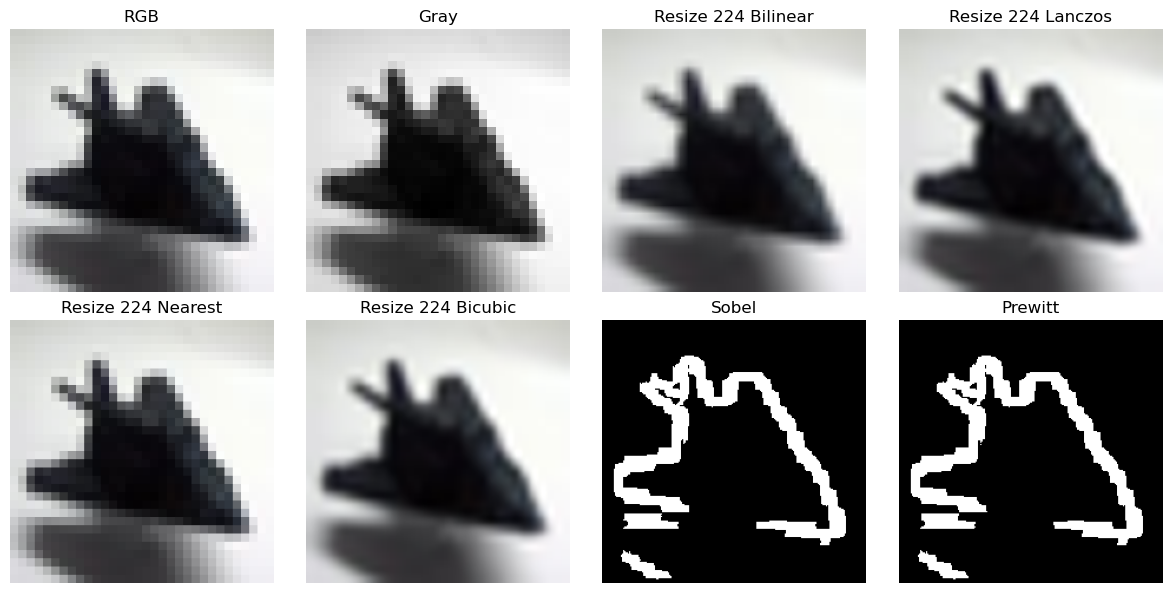

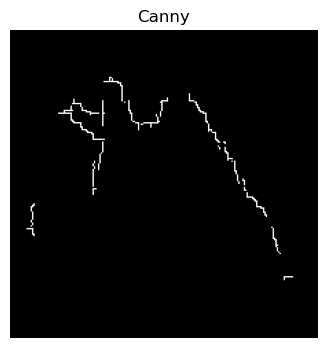

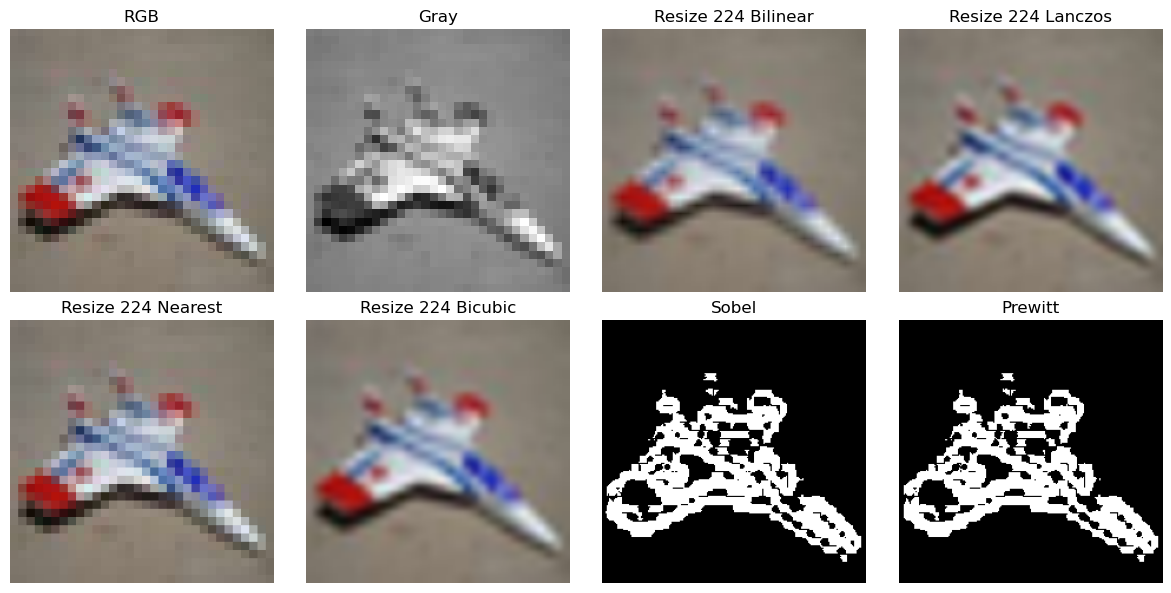

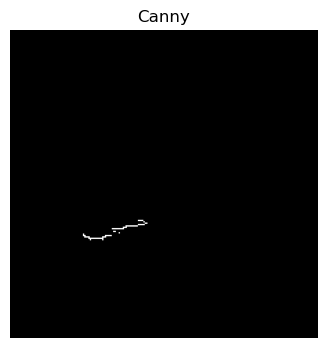

In [11]:
# CELL 11 — Visual examples
import matplotlib.pyplot as plt

samples = paths[:2]
for p in samples:
    im = Image.open(p).convert("RGB")
    gray = ImageOps.grayscale(im)
    r224 = {k: letterbox_resize(im, (224,224), PAD_COLOR, v) for k,v in PIL_INTERP.items()}
    g224 = ImageOps.grayscale(r224["bilinear"])
    eS, eP, eC = edges_sobel(np.asarray(g224)), edges_prewitt(np.asarray(g224)), edges_canny(np.asarray(g224))

    fig, ax = plt.subplots(2,4, figsize=(12,6)); ax=ax.ravel()
    ax[0].imshow(im); ax[0].set_title("RGB");  ax[0].axis("off")
    ax[1].imshow(gray, cmap="gray"); ax[1].set_title("Gray"); ax[1].axis("off")
    ax[2].imshow(r224["bilinear"]); ax[2].set_title("Resize 224 Bilinear"); ax[2].axis("off")
    ax[3].imshow(r224["lanczos"]);  ax[3].set_title("Resize 224 Lanczos");  ax[3].axis("off")
    ax[4].imshow(r224["nearest"]);  ax[4].set_title("Resize 224 Nearest");  ax[4].axis("off")
    ax[5].imshow(r224["bicubic"]);  ax[5].set_title("Resize 224 Bicubic");  ax[5].axis("off")
    ax[6].imshow(eS, cmap="gray");  ax[6].set_title("Sobel");   ax[6].axis("off")
    ax[7].imshow(eP, cmap="gray");  ax[7].set_title("Prewitt"); ax[7].axis("off")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,4)); plt.imshow(eC, cmap="gray"); plt.title("Canny"); plt.axis("off"); plt.show()


In [12]:
# CELL 12 — Plot setup
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

FIG_DIR = OUT_PREP / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.35

print("📁 Figures will be saved to:", FIG_DIR)


📁 Figures will be saved to: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs


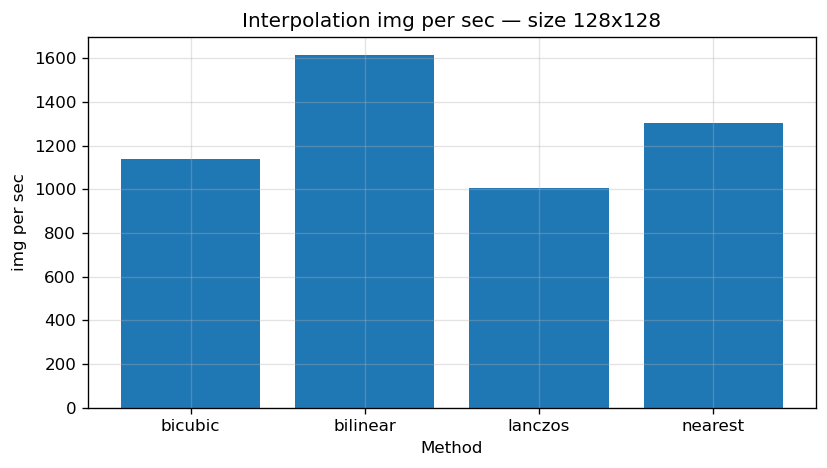

💾 Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_img_per_sec_128x128.png


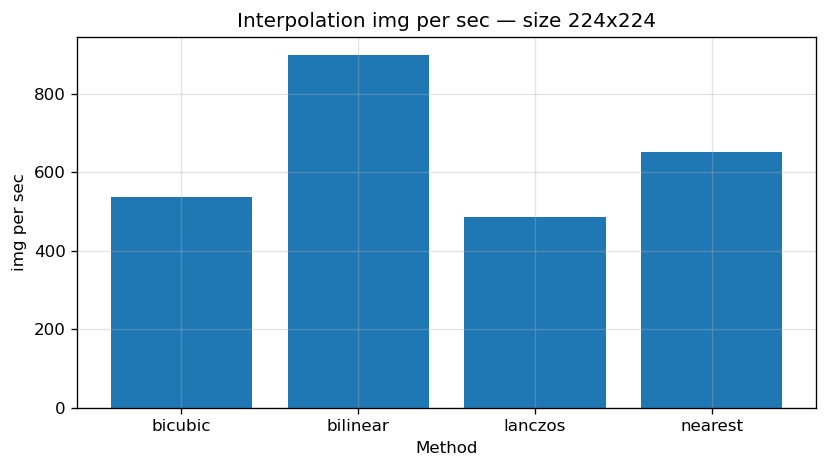

💾 Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_img_per_sec_224x224.png


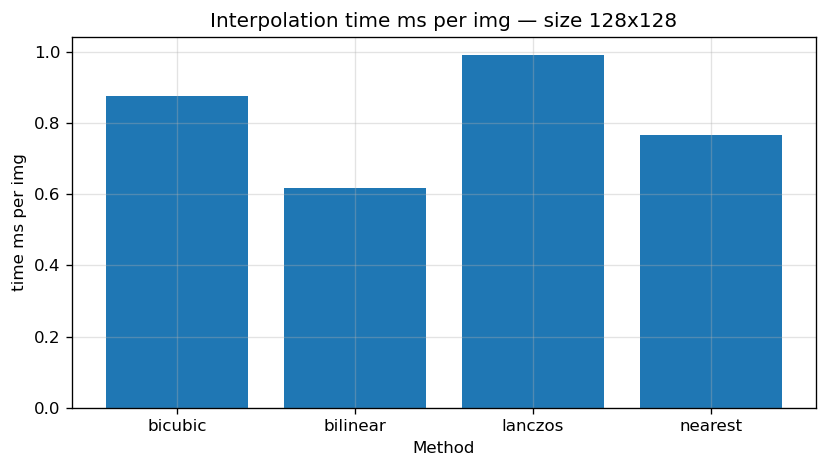

💾 Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_time_ms_per_img_128x128.png


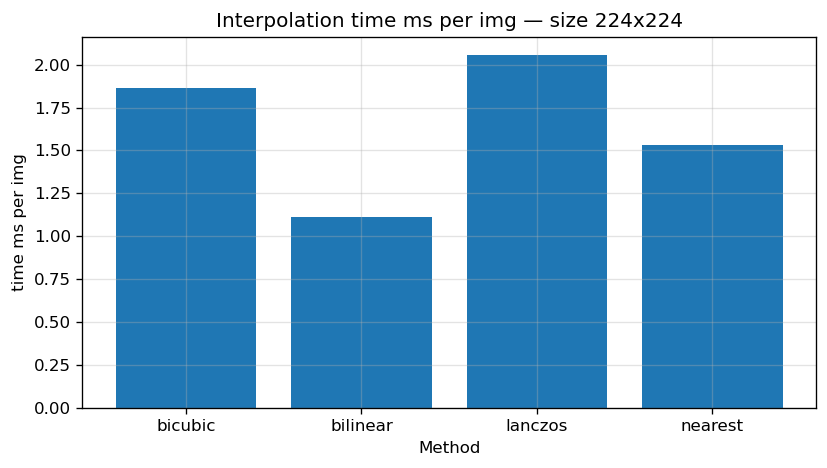

💾 Saved: d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_time_ms_per_img_224x224.png


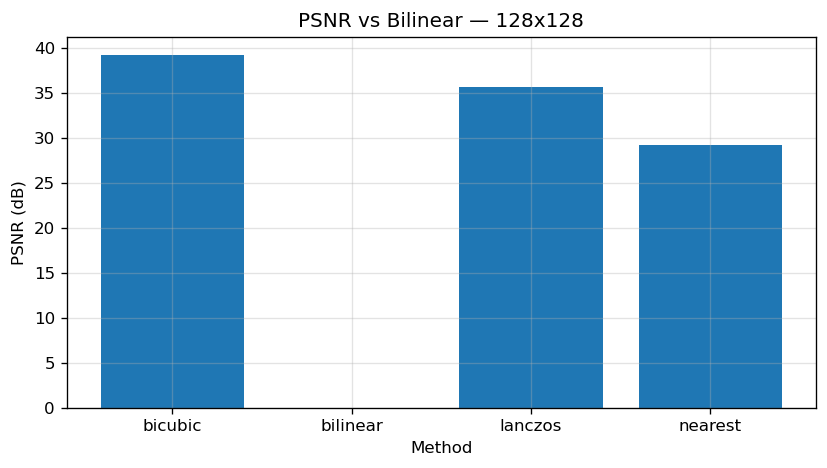

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_psnr_128x128.png


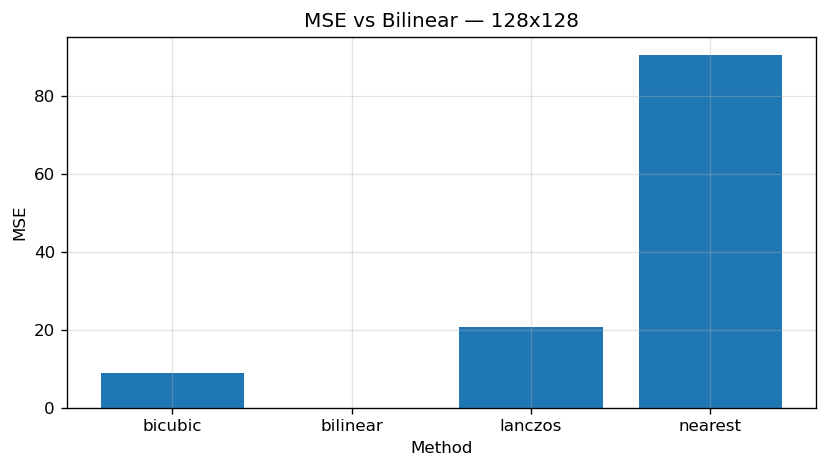

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_mse_128x128.png


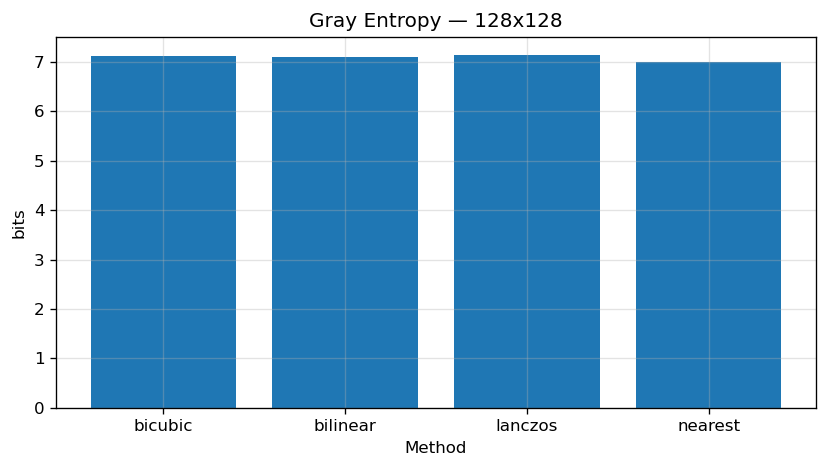

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_entropy_128x128.png


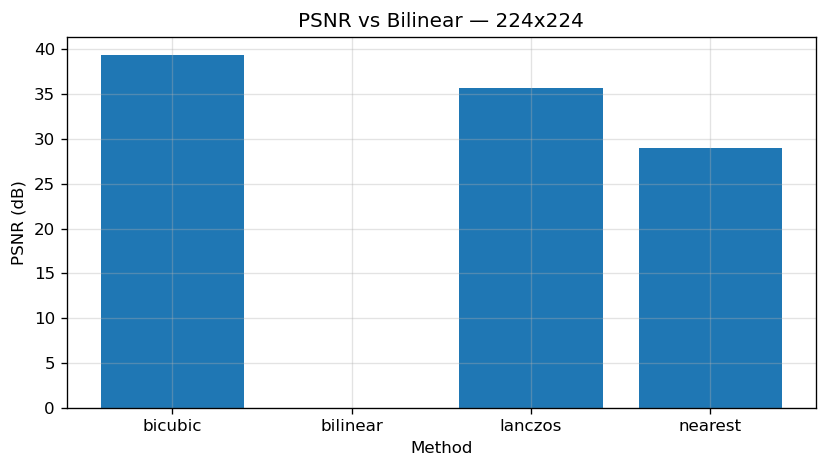

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_psnr_224x224.png


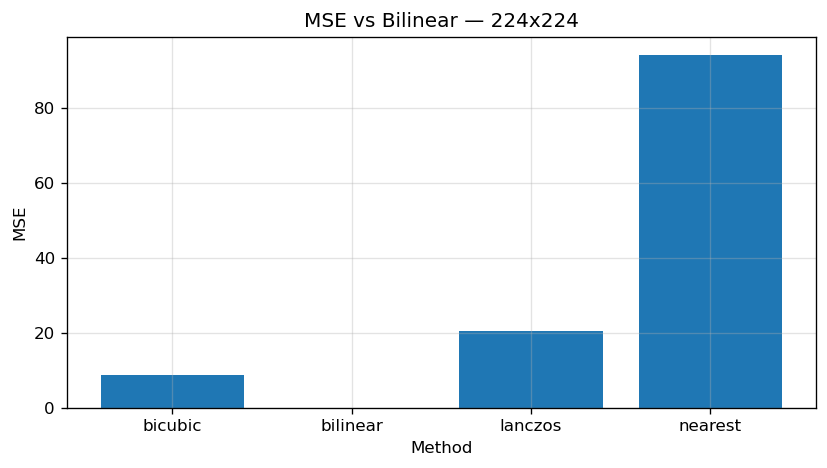

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_mse_224x224.png


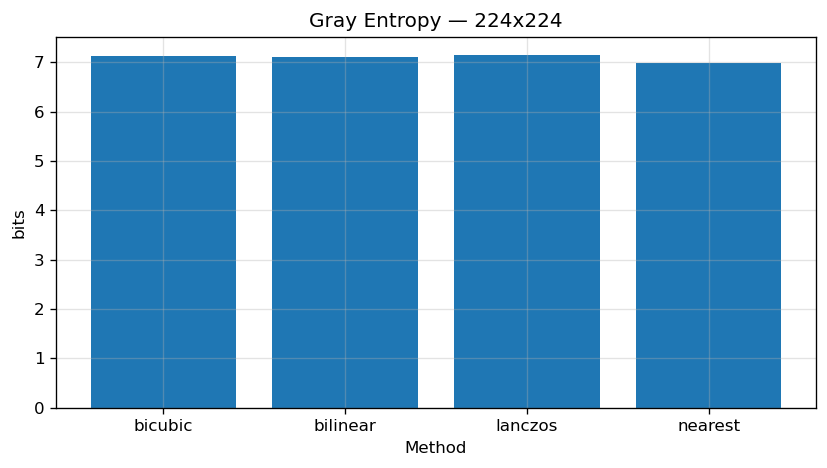

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\interp_entropy_224x224.png


In [13]:
# CELL 13 — Interpolation plots (speed + quality)
interp_bench_path   = OUT_PREP / "interp_benchmark.csv"
interp_quality_path = OUT_PREP / "interp_quality.csv"

df_bench = pd.read_csv(interp_bench_path)
df_qual  = pd.read_csv(interp_quality_path)

# --- Speed (images/sec) theo method, tách theo size ---
for metric in ["img_per_sec", "time_ms_per_img"]:
    for sz in sorted(df_bench["size"].unique()):
        d = df_bench[df_bench["size"]==sz]
        plt.figure(figsize=(7,4))
        plt.bar(d["method"], d[metric])
        plt.title(f"Interpolation {metric.replace('_',' ')} — size {sz}")
        plt.xlabel("Method"); plt.ylabel(metric.replace('_',' '))
        plt.tight_layout()
        out = FIG_DIR / f"interp_{metric}_{sz}.png"
        plt.savefig(out, bbox_inches="tight"); plt.show()
        print("💾 Saved:", out)

# --- Quality vs bilinear: PSNR, MSE, Entropy ---
for sz in sorted(df_qual["size"].unique()):
    d = df_qual[df_qual["size"]==sz].copy()

    # PSNR (skip bilinear = NaN)
    plt.figure(figsize=(7,4))
    plt.bar(d["method"], d["psnr_vs_bilinear_mean"])
    plt.title(f"PSNR vs Bilinear — {sz}"); plt.ylabel("PSNR (dB)"); plt.xlabel("Method")
    plt.tight_layout()
    out = FIG_DIR / f"interp_psnr_{sz}.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

    # MSE (skip bilinear = NaN)
    plt.figure(figsize=(7,4))
    plt.bar(d["method"], d["mse_vs_bilinear_mean"])
    plt.title(f"MSE vs Bilinear — {sz}"); plt.ylabel("MSE"); plt.xlabel("Method")
    plt.tight_layout()
    out = FIG_DIR / f"interp_mse_{sz}.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

    # Entropy (mọi method đều có)
    plt.figure(figsize=(7,4))
    plt.bar(d["method"], d["entropy_mean"])
    plt.title(f"Gray Entropy — {sz}"); plt.ylabel("bits"); plt.xlabel("Method")
    plt.tight_layout()
    out = FIG_DIR / f"interp_entropy_{sz}.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)


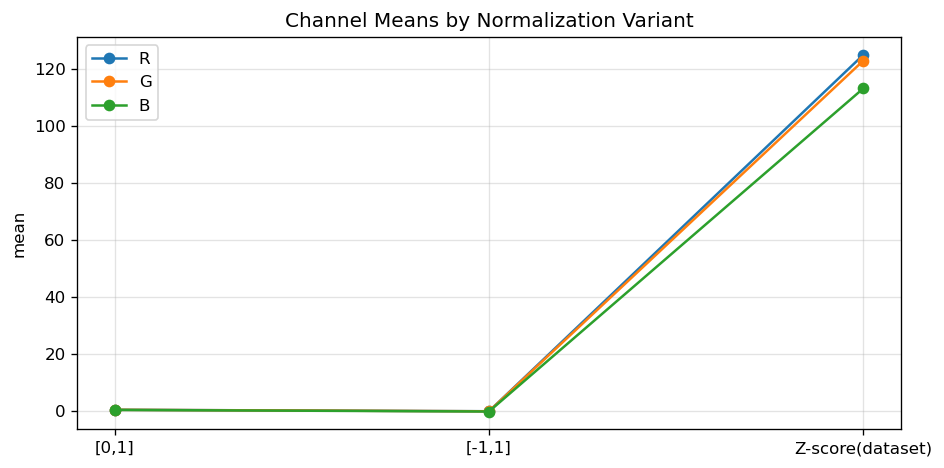

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\norm_means.png


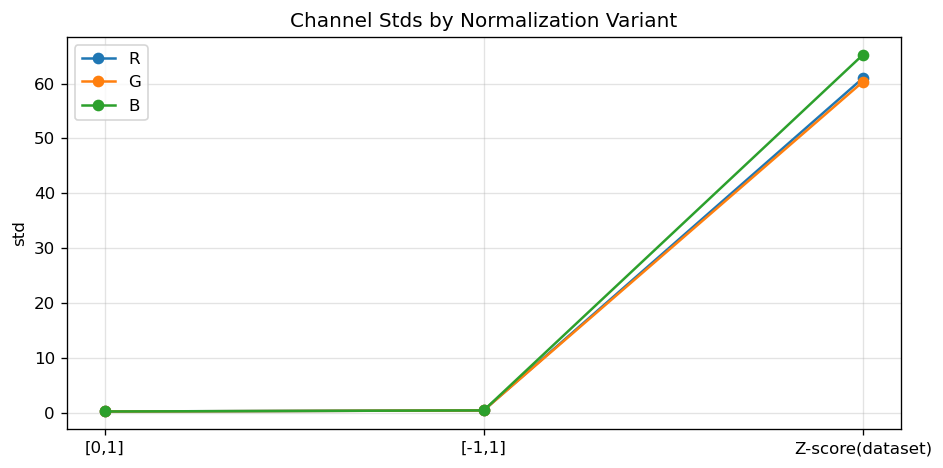

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\norm_stds.png


In [14]:
# CELL 14 — Normalization plots
norm_path = OUT_PREP / "normalization_stats.csv"
dfn = pd.read_csv(norm_path)

# Mean per channel
plt.figure(figsize=(8,4))
x = range(len(dfn["variant"]))
plt.plot(x, dfn["mean_R"], marker="o", label="R")
plt.plot(x, dfn["mean_G"], marker="o", label="G")
plt.plot(x, dfn["mean_B"], marker="o", label="B")
plt.xticks(x, dfn["variant"])
plt.title("Channel Means by Normalization Variant")
plt.ylabel("mean"); plt.legend(); plt.tight_layout()
out = FIG_DIR / "norm_means.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

# Std per channel
plt.figure(figsize=(8,4))
plt.plot(x, dfn["std_R"], marker="o", label="R")
plt.plot(x, dfn["std_G"], marker="o", label="G")
plt.plot(x, dfn["std_B"], marker="o", label="B")
plt.xticks(x, dfn["variant"])
plt.title("Channel Stds by Normalization Variant")
plt.ylabel("std"); plt.legend(); plt.tight_layout()
out = FIG_DIR / "norm_stds.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)


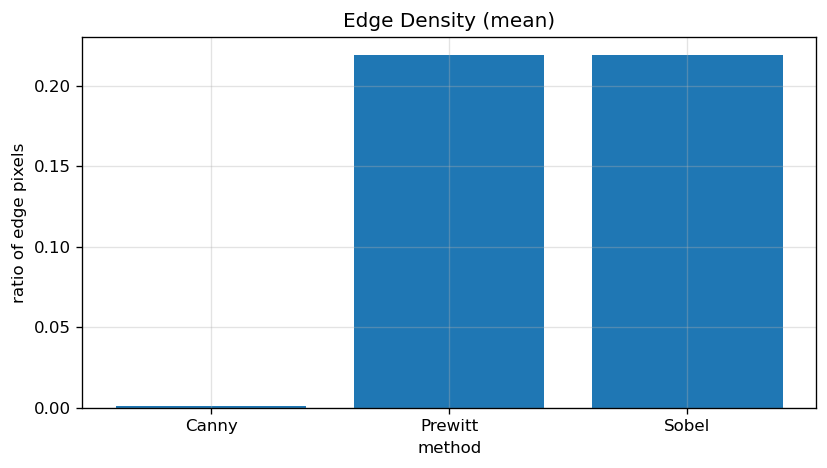

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\edges_density_mean.png


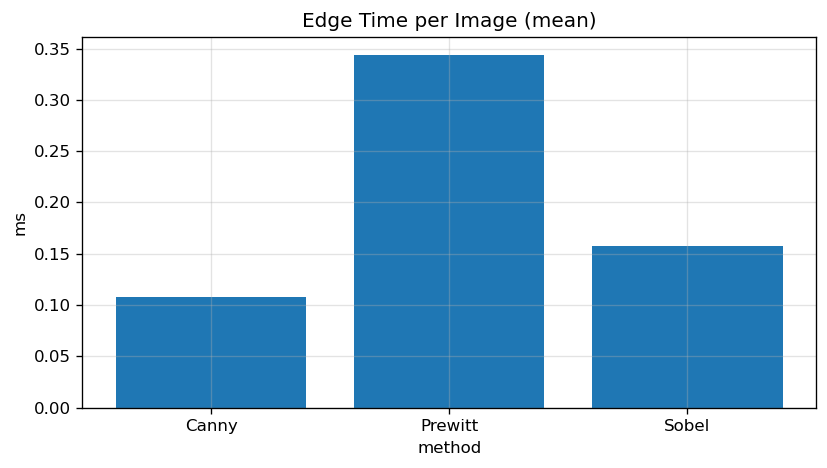

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\edges_time_mean.png


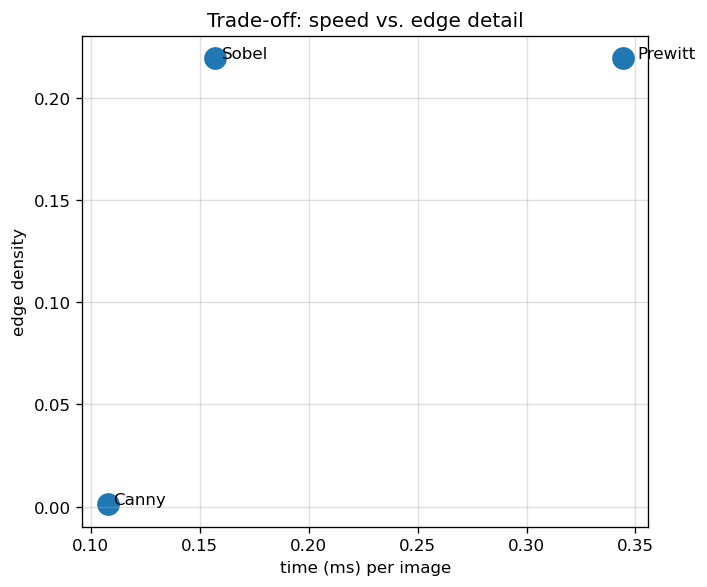

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\edges_tradeoff_scatter.png


In [15]:
# CELL 15 — Edge detector plots (use <MEAN> rows)
edges_path = OUT_PREP / "edges_per_image.csv"
dfe_all = pd.read_csv(edges_path)

# Lấy dòng <MEAN>
dfe = dfe_all[dfe_all["ID"]=="<MEAN>"].copy()

# Bar: edge density
plt.figure(figsize=(7,4))
plt.bar(dfe["method"], dfe["edge density"])
plt.title("Edge Density (mean)")
plt.ylabel("ratio of edge pixels"); plt.xlabel("method")
plt.tight_layout()
out = FIG_DIR / "edges_density_mean.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

# Bar: time
plt.figure(figsize=(7,4))
plt.bar(dfe["method"], dfe["time (ms)"])
plt.title("Edge Time per Image (mean)")
plt.ylabel("ms"); plt.xlabel("method")
plt.tight_layout()
out = FIG_DIR / "edges_time_mean.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

# Scatter: speed vs detail
plt.figure(figsize=(6,5))
plt.scatter(dfe["time (ms)"], dfe["edge density"], s=160)
for _, r in dfe.iterrows():
    plt.text(r["time (ms)"]*1.02, r["edge density"], r["method"])
plt.xlabel("time (ms) per image"); plt.ylabel("edge density")
plt.title("Trade-off: speed vs. edge detail"); plt.grid(alpha=0.4)
plt.tight_layout()
out = FIG_DIR / "edges_tradeoff_scatter.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)


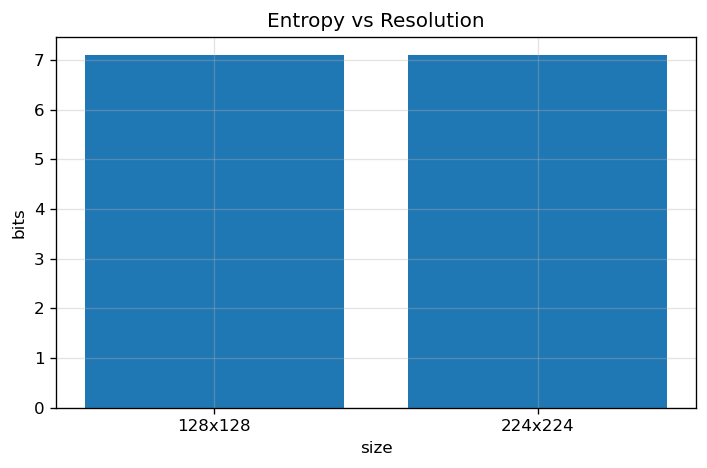

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\resolution_entropy.png


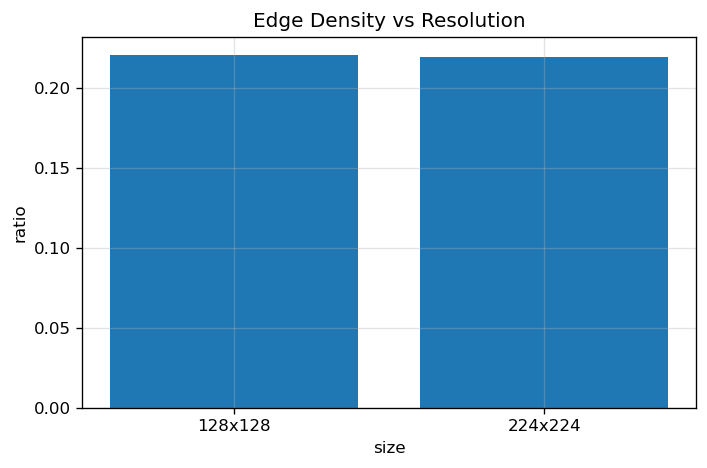

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\resolution_edge_density.png


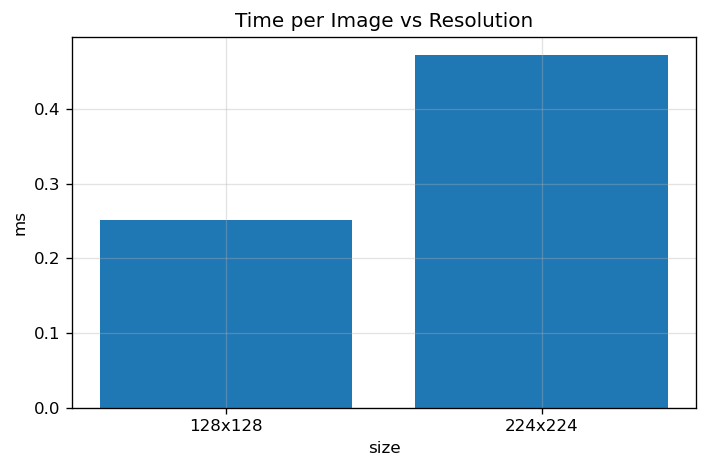

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\resolution_time.png


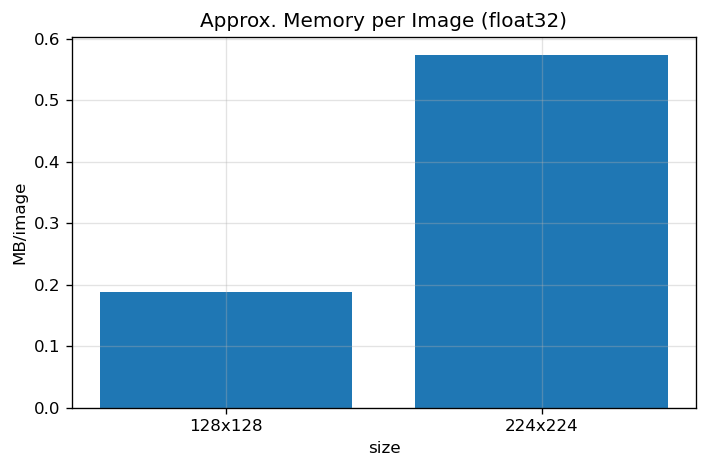

💾 d:\Vũ Anh\HK 7\Data Mining\Lab 1\Lab-01---Data-preprocessing\output\preprocess\figs\resolution_memory.png


In [16]:
# CELL 16 — Resolution trade-off plots
res_path = OUT_PREP / "resolution_tradeoff.csv"
dfr = pd.read_csv(res_path)

# Entropy
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["entropy_mean"])
plt.title("Entropy vs Resolution"); plt.ylabel("bits"); plt.xlabel("size")
plt.tight_layout()
out = FIG_DIR / "resolution_entropy.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

# Edge density
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["edge_density_mean"])
plt.title("Edge Density vs Resolution"); plt.ylabel("ratio"); plt.xlabel("size")
plt.tight_layout()
out = FIG_DIR / "resolution_edge_density.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

# Time per image
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["time_ms_per_img"])
plt.title("Time per Image vs Resolution"); plt.ylabel("ms"); plt.xlabel("size")
plt.tight_layout()
out = FIG_DIR / "resolution_time.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)

# Memory approximation
plt.figure(figsize=(6,4))
plt.bar(dfr["size"], dfr["approx_mem_per_img_MB(float32)"])
plt.title("Approx. Memory per Image (float32)"); plt.ylabel("MB/image"); plt.xlabel("size")
plt.tight_layout()
out = FIG_DIR / "resolution_memory.png"; plt.savefig(out, bbox_inches="tight"); plt.show(); print("💾", out)
